# 📊 Advanced Visualizations & Dashboard Preview

This notebook showcases advanced visualizations and prepares data for Power BI.

## Contents
1. Interactive Charts
2. Heatmaps & Correlation
3. Executive Summary
4. Power BI Data Export

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '..')

from src.visualization.plots import TrafficVisualizer
from src.visualization.powerbi_export import PowerBIExporter

print('✅ Modules loaded!')

✅ Modules loaded!


In [2]:
# Load data
time_data = pd.read_csv('../data/processed/accidents_time_processed.csv')
month_data = pd.read_csv('../data/processed/accidents_month_processed.csv')
severity_data = pd.read_csv('../data/processed/accidents_severity_processed.csv')

# Clean totals
severity_clean = severity_data[~severity_data['State'].str.contains('Total', case=False, na=False)]
time_clean = time_data[~time_data['State'].str.contains('Total', case=False, na=False)]

print('✅ Data loaded!')

✅ Data loaded!


## 1. Interactive Charts

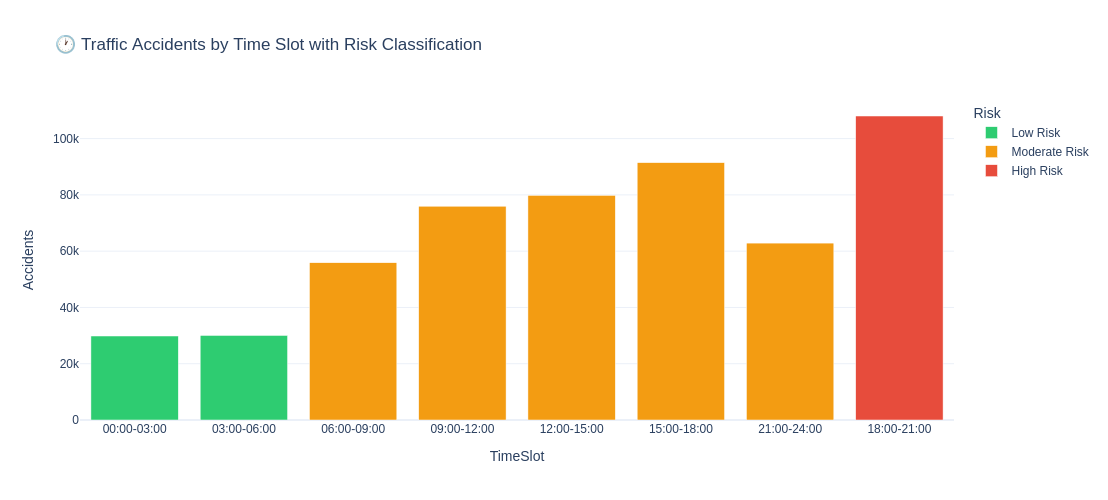

In [3]:
# Time slot analysis with animation
time_agg = time_clean.groupby('TimeSlot')['Accidents'].sum().reset_index()
time_order = ['00:00-03:00', '03:00-06:00', '06:00-09:00', '09:00-12:00',
              '12:00-15:00', '15:00-18:00', '18:00-21:00', '21:00-24:00']
time_agg['TimeOrder'] = time_agg['TimeSlot'].apply(lambda x: time_order.index(x))
time_agg = time_agg.sort_values('TimeOrder')

# Add classification
mean_val = time_agg['Accidents'].mean()
std_val = time_agg['Accidents'].std()
time_agg['Risk'] = time_agg['Accidents'].apply(
    lambda x: 'High Risk' if x > mean_val + std_val else 
              ('Low Risk' if x < mean_val - std_val else 'Moderate Risk')
)

fig = px.bar(time_agg, x='TimeSlot', y='Accidents', color='Risk',
             color_discrete_map={'High Risk': '#e74c3c', 'Moderate Risk': '#f39c12', 'Low Risk': '#2ecc71'},
             title='🕐 Traffic Accidents by Time Slot with Risk Classification')
fig.update_layout(template='plotly_white', height=500)
fig.show()

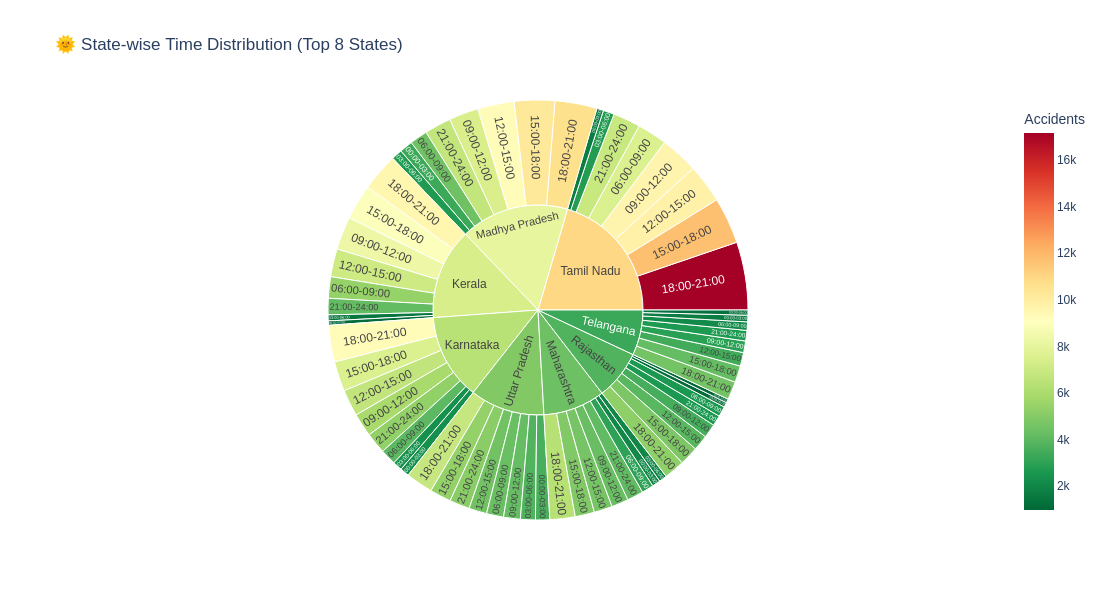

In [4]:
# Sunburst chart - State > Time distribution
top_states = time_clean.groupby('State')['Accidents'].sum().nlargest(8).index
sunburst_data = time_clean[time_clean['State'].isin(top_states)]

fig = px.sunburst(sunburst_data, path=['State', 'TimeSlot'], values='Accidents',
                  title='🌞 State-wise Time Distribution (Top 8 States)',
                  color='Accidents', color_continuous_scale='RdYlGn_r')
fig.update_layout(height=600)
fig.show()

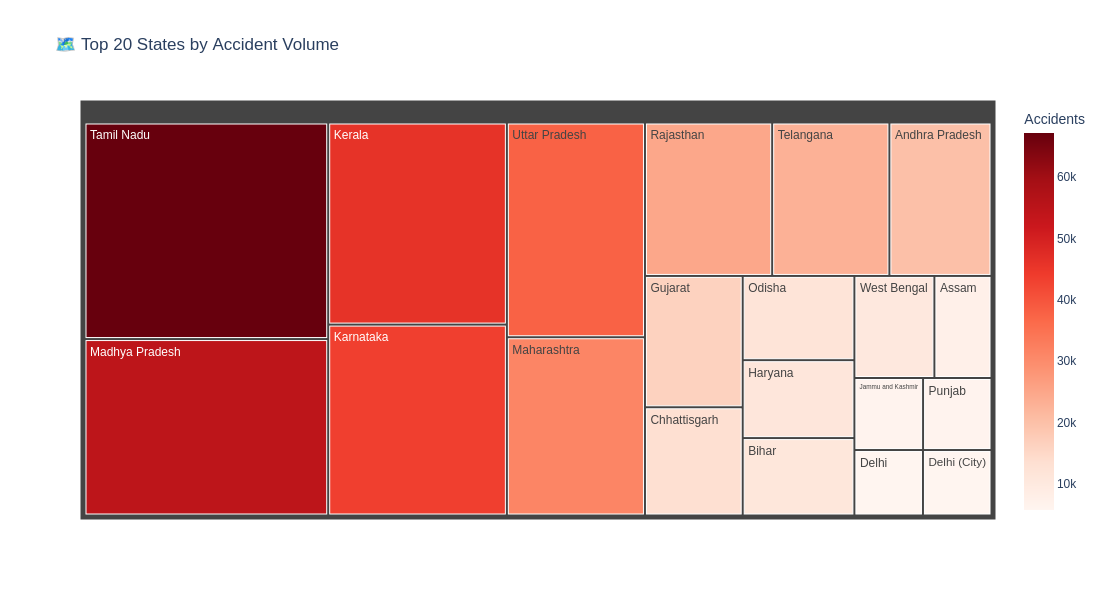

In [5]:
# Treemap - Accidents by State
state_summary = time_clean.groupby('State')['Accidents'].sum().reset_index()
state_summary = state_summary.nlargest(20, 'Accidents')

fig = px.treemap(state_summary, path=['State'], values='Accidents',
                 title='🗺️ Top 20 States by Accident Volume',
                 color='Accidents', color_continuous_scale='Reds')
fig.update_layout(height=600)
fig.show()

## 2. Heatmaps & Correlation

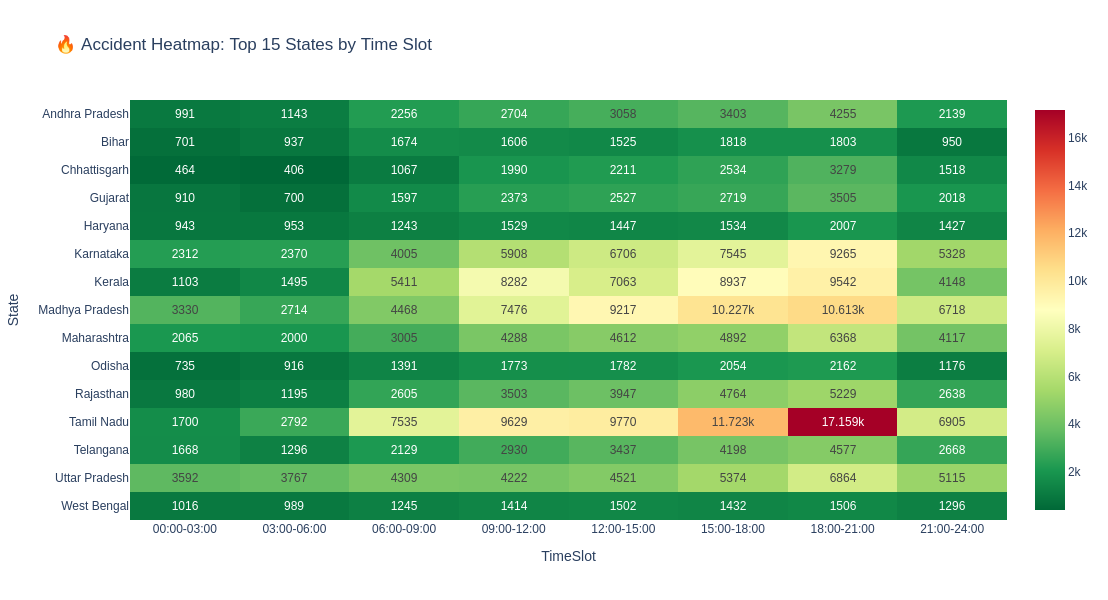

In [6]:
# State-Time Heatmap
top_15_states = time_clean.groupby('State')['Accidents'].sum().nlargest(15).index
heatmap_data = time_clean[time_clean['State'].isin(top_15_states)]
pivot = heatmap_data.pivot_table(index='State', columns='TimeSlot', values='Accidents', aggfunc='sum')

# Order columns
pivot = pivot[[c for c in time_order if c in pivot.columns]]

fig = px.imshow(pivot, text_auto=True, aspect='auto',
                title='🔥 Accident Heatmap: Top 15 States by Time Slot',
                color_continuous_scale='RdYlGn_r')
fig.update_layout(height=600, template='plotly_white')
fig.show()

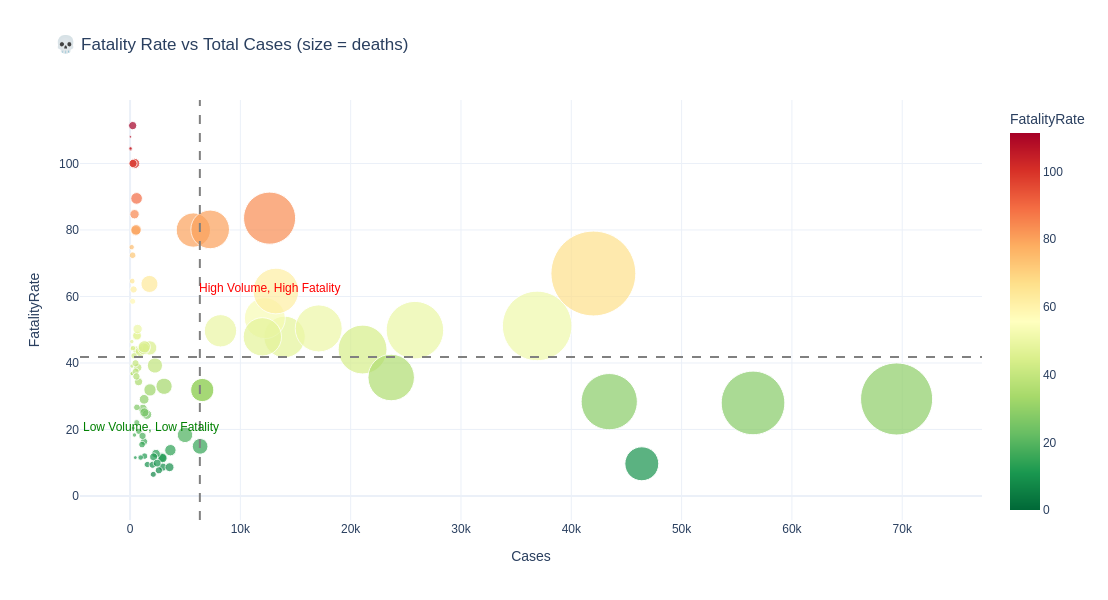

In [7]:
# Scatter plot - Fatality vs Cases with size = Deaths
fig = px.scatter(severity_clean, x='Cases', y='FatalityRate', size='Died',
                 color='FatalityRate', hover_name='State',
                 color_continuous_scale='RdYlGn_r', size_max=60,
                 title='💀 Fatality Rate vs Total Cases (size = deaths)')

# Add quadrant lines
avg_cases = severity_clean['Cases'].mean()
avg_fatality = severity_clean['FatalityRate'].mean()
fig.add_hline(y=avg_fatality, line_dash='dash', line_color='gray')
fig.add_vline(x=avg_cases, line_dash='dash', line_color='gray')

fig.add_annotation(x=avg_cases*2, y=avg_fatality*1.5, text='High Volume, High Fatality',
                   showarrow=False, font=dict(color='red'))
fig.add_annotation(x=avg_cases*0.3, y=avg_fatality*0.5, text='Low Volume, Low Fatality',
                   showarrow=False, font=dict(color='green'))

fig.update_layout(template='plotly_white', height=600)
fig.show()

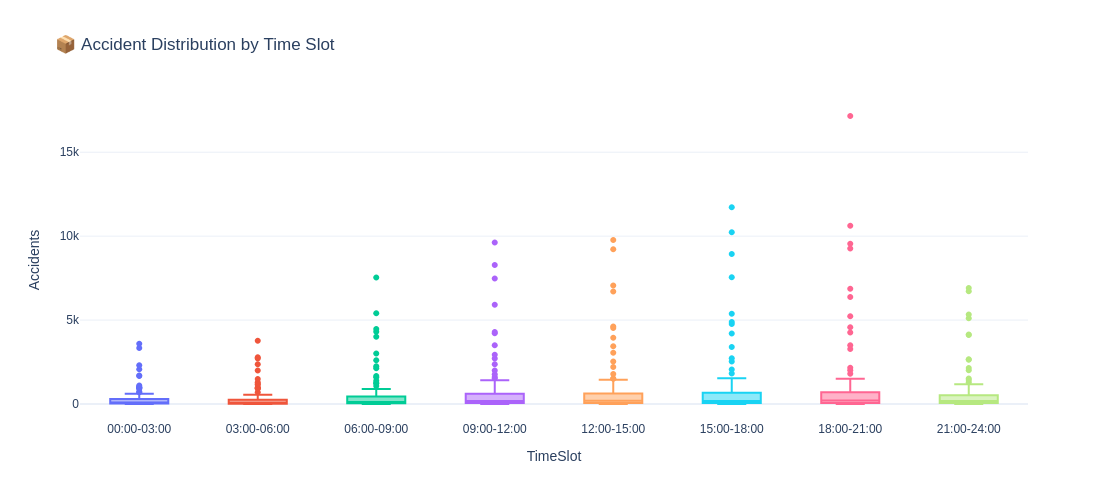

In [8]:
# Box plot - Accident distribution by time
fig = px.box(time_clean, x='TimeSlot', y='Accidents',
             title='📦 Accident Distribution by Time Slot',
             color='TimeSlot')
fig.update_layout(template='plotly_white', height=500, showlegend=False,
                  xaxis={'categoryorder': 'array', 'categoryarray': time_order})
fig.show()

## 3. Executive Summary Dashboard

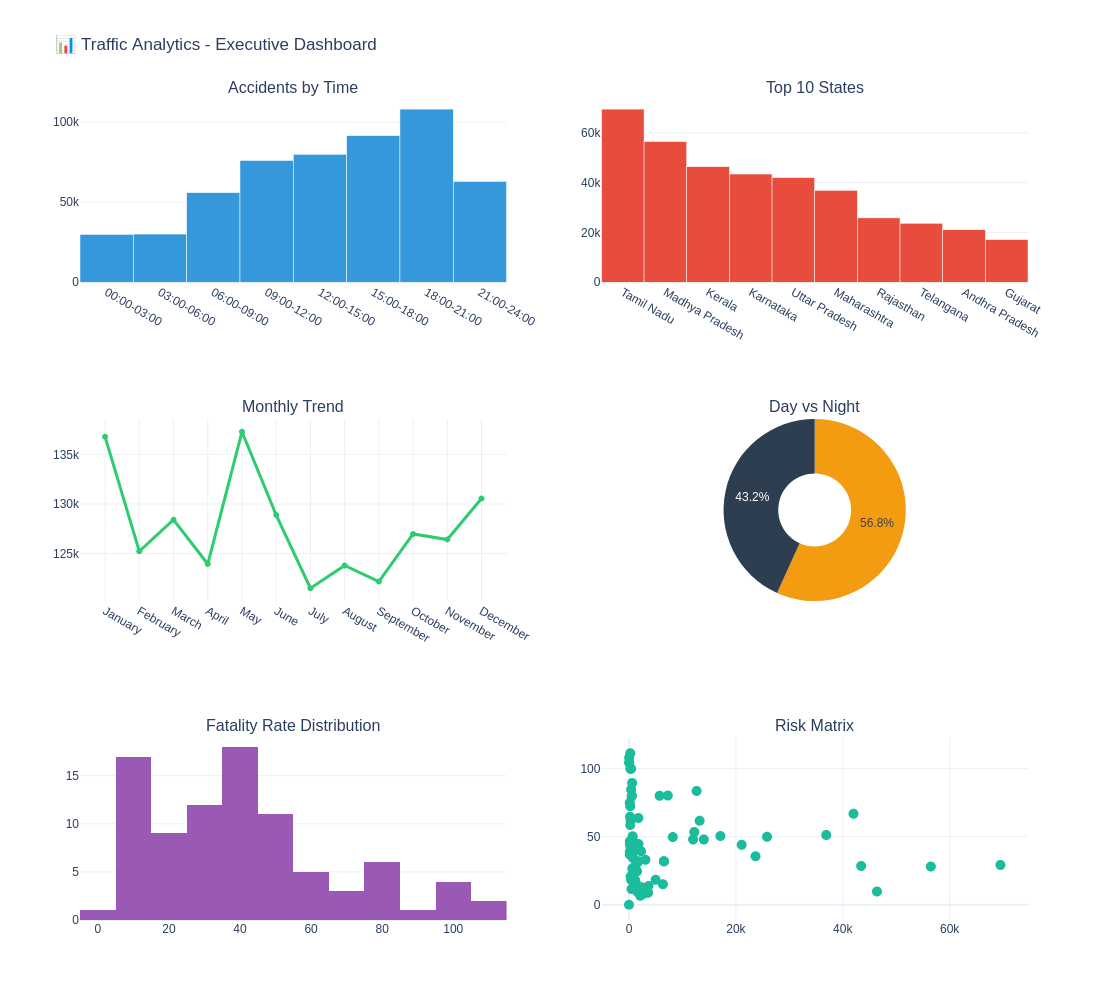

In [9]:
# Create executive dashboard
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Accidents by Time', 'Top 10 States',
        'Monthly Trend', 'Day vs Night',
        'Fatality Rate Distribution', 'Risk Matrix'
    ),
    specs=[
        [{}, {}],
        [{}, {'type': 'pie'}],
        [{}, {}]
    ]
)

# 1. Accidents by Time
fig.add_trace(
    go.Bar(x=time_agg['TimeSlot'], y=time_agg['Accidents'], marker_color='#3498db'),
    row=1, col=1
)

# 2. Top 10 States
top_10 = severity_clean.nlargest(10, 'Cases')
fig.add_trace(
    go.Bar(x=top_10['State'], y=top_10['Cases'], marker_color='#e74c3c'),
    row=1, col=2
)

# 3. Monthly Trend
monthly = month_data.groupby(['Month', 'MonthNum'])['Accidents'].sum().reset_index().sort_values('MonthNum')
fig.add_trace(
    go.Scatter(x=monthly['Month'], y=monthly['Accidents'], mode='lines+markers',
               line=dict(color='#2ecc71', width=3)),
    row=2, col=1
)

# 4. Day vs Night Pie
day_slots = ['06:00-09:00', '09:00-12:00', '12:00-15:00', '15:00-18:00']
day_total = time_clean[time_clean['TimeSlot'].isin(day_slots)]['Accidents'].sum()
night_total = time_clean[~time_clean['TimeSlot'].isin(day_slots)]['Accidents'].sum()
fig.add_trace(
    go.Pie(labels=['Day', 'Night'], values=[day_total, night_total],
           marker_colors=['#f39c12', '#2c3e50'], hole=0.4),
    row=2, col=2
)

# 5. Fatality Distribution
fig.add_trace(
    go.Histogram(x=severity_clean['FatalityRate'], nbinsx=15, marker_color='#9b59b6'),
    row=3, col=1
)

# 6. Risk Matrix (Cases vs Fatality)
fig.add_trace(
    go.Scatter(x=severity_clean['Cases'], y=severity_clean['FatalityRate'],
               mode='markers', marker=dict(size=10, color='#1abc9c')),
    row=3, col=2
)

fig.update_layout(
    height=1000, template='plotly_white', showlegend=False,
    title_text='📊 Traffic Analytics - Executive Dashboard'
)
fig.show()

In [13]:
# KPI Cards
total_accidents = severity_clean['Cases'].sum()
total_deaths = severity_clean['Died'].sum()
total_injured = severity_clean['Injured'].sum()
avg_fatality = severity_clean['FatalityRate'].mean()

print('='*60)
print('                    KEY PERFORMANCE INDICATORS')
print('='*60)
print(f'''
┌─────────────────────┬─────────────────────┐
│   TOTAL ACCIDENTS   │     TOTAL DEATHS    │
│     {total_accidents:>10,}      │      {total_deaths:>10,}     │
├─────────────────────┼─────────────────────┤
│   TOTAL INJURED     │   AVG FATALITY RATE │
│     {total_injured:>10,}      │        {avg_fatality:>6.2f}%      │
└─────────────────────┴─────────────────────┘

📍 Peak Hour: 18:00-21:00 (Evening Rush)
📅 Peak Month: May
🏆 Highest Accidents: {severity_clean.loc[severity_clean['Cases'].idxmax(), 'State']}
⚠️  Highest Fatality: {severity_clean.loc[severity_clean['FatalityRate'].idxmax(), 'State']}
''')

                    KEY PERFORMANCE INDICATORS

┌─────────────────────┬─────────────────────┐
│   TOTAL ACCIDENTS   │     TOTAL DEATHS    │
│        563,011      │         215,782     │
├─────────────────────┼─────────────────────┤
│   TOTAL INJURED     │   AVG FATALITY RATE │
│        515,210      │         41.79%      │
└─────────────────────┴─────────────────────┘

📍 Peak Hour: 18:00-21:00 (Evening Rush)
📅 Peak Month: May
🏆 Highest Accidents: Tamil Nadu
⚠️  Highest Fatality: Varanasi



## 4. Power BI Data Export

In [11]:
# Export data for Power BI
exporter = PowerBIExporter(output_dir='../outputs/powerbi')
exporter.load_processed_data()
result = exporter.export_all()

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/accidents_time_processed.csv'

In [ ]:
# Show exported files
print('📁 EXPORTED FILES FOR POWER BI')
print('='*60)
for category, files in result.items():
    print(f"\n{category.upper()}:")
    for f in files:
        print(f"  → {f}")

In [ ]:
# Preview KPI data
import json
with open('../outputs/powerbi/summary_kpi.json', 'r') as f:
    kpis = json.load(f)

print('📊 KPI DATA FOR POWER BI CARDS')
print('='*60)
for key, value in kpis.items():
    print(f"{key}: {value}")

## 📝 Summary

### Visualizations Created
- Interactive bar charts with risk classification
- Sunburst & Treemap for hierarchical data
- Heatmaps for state-time patterns
- Scatter plots with quadrant analysis
- Executive dashboard with 6 key charts

### Power BI Files Exported
- Fact tables: `fact_accidents_time.csv`, `fact_accidents_monthly.csv`
- Dimension tables: `dim_states.csv` (with Region, RiskCategory)
- KPI data: `summary_kpi.csv`, `summary_kpi.json`
- Aggregated views for faster loading

### Next Steps
1. Import CSV files into Power BI
2. Create relationships between fact and dimension tables
3. Build interactive dashboards with slicers
4. Add DAX measures for calculated metrics

---
*End of Notebook Series*